# Importing Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import glob
import convolution as con
import random

# Importing Images

In [2]:
x=list()
y=list()
pos=glob.glob("Concrete/Positive/*")
neg=glob.glob("Concrete/Negative/*")
for i in range(20000):
    img=cv2.imread(pos[i],0)
    img=cv2.resize(img,(128,128))
    img=img.reshape(128,128,1)
    x.append(img)
    y.append([1,0])
    img=cv2.imread(neg[i],0)
    img=cv2.resize(img,(128,128))
    img=img.reshape(128,128,1)
    x.append(img)
    y.append([0,1])
    print("Image number : %d"%(i+1),end='\r')
print("Done")
x=np.asarray(x)
x=np.float32(x)
x/=255
y=np.asarray(y)
y=np.uint8(y)
np.save('x.npy',x)
np.save('y.npy',y)
del(pos)
del(neg)
del(img)

Donee number : 20000


In [3]:
x=np.load('x.npy')
y=np.load('y.npy')

# Processing the image

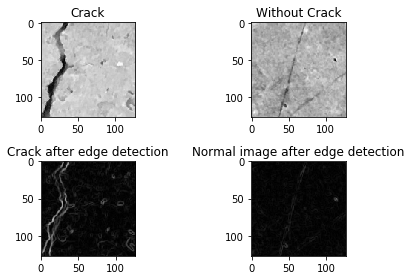

In [4]:
kernel1=np.asarray([[1,0,-1],[1,0,-1],[1,0,-1]])
kernel2=np.asarray([[1,1,1],[0,0,0],[-1,-1,-1]])
pos=random.randint(0,10000)*2
neg=random.randint(0,10000)*2+1
pos=x[pos].reshape((128,128))
neg=x[neg].reshape((128,128))
posedge=np.sqrt(con.convolution(pos,kernel1)**2+con.convolution(pos,kernel2)**2)
negedge=np.sqrt(con.convolution(neg,kernel1)**2+con.convolution(neg,kernel2)**2)
ax3=plt.subplot(2,2,1)
ax3.imshow(pos,cmap='gray')
ax3.set_title('Crack')
ax4=plt.subplot(2,2,2)
ax4.imshow(neg,cmap='gray')
ax4.set_title('Without Crack')
ax1=plt.subplot(2,2,3)
ax1.imshow(posedge,cmap='gray')
ax1.set_title('Crack after edge detection')
ax2=plt.subplot(2,2,4)
ax2.imshow(negedge,cmap='gray')
ax2.set_title('Normal image after edge detection')
plt.tight_layout()
plt.show()